In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image

import torch
from torchvision import transforms


In [3]:
# 
data_root = "Shop DataSet\Shop DataSet"
output_root = "processed_clips"
classes = ["non shop lifters", "shop lifters"]
clip_length = 8
target_size = (112, 112)


In [4]:
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Optional but helpful
])


In [5]:
def extract_clips_from_video(video_path, save_dir, label, clip_length=16):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_frame = Image.fromarray(frame)
        frame_tensor = transform(pil_frame)
        frames.append(frame_tensor)

    cap.release()

    # Now slice into clips
    clips = []
    for i in range(0, len(frames) - clip_length + 1, clip_length):
        clip = torch.stack(frames[i:i+clip_length])  # Shape: [clip_length, C, H, W]
        clips.append(clip)

    for j, clip in enumerate(clips):
        clip_path = os.path.join(save_dir, f"{Path(video_path).stem}_clip{j}_{label}.pt")
        torch.save(clip, clip_path)


In [6]:
for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_root, class_name)
    save_dir = os.path.join(output_root, class_name.replace(" ", "_"))

    video_files = [f for f in os.listdir(class_dir) if f.endswith(('.mp4', '.avi'))]
    for video_file in tqdm(video_files, desc=f"Processing {class_name}"):
        video_path = os.path.join(class_dir, video_file)
        extract_clips_from_video(video_path, save_dir, label, clip_length)


Processing non shop lifters:   0%|          | 0/531 [00:00<?, ?it/s]

Processing shop lifters: 100%|██████████| 324/324 [06:10<00:00,  1.14s/it]


C:\Users\youss\AppData\Local\Temp\ipykernel_13652\48388415.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip = torch.load(clip_path)  # shape: [16, 3, 224, 224]
Clipp

Clip shape: torch.Size([8, 3, 112, 112])


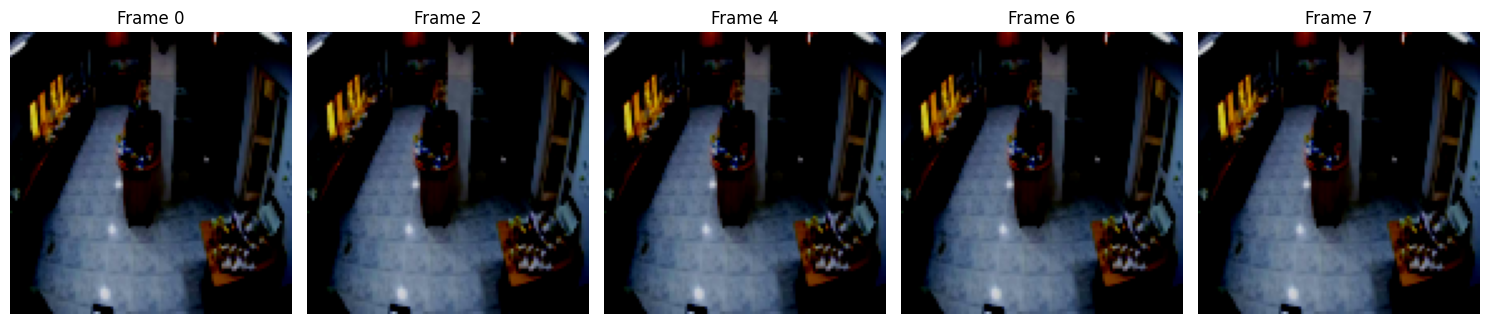

In [7]:
import torch
import matplotlib.pyplot as plt

# Pick a clip path
clip_path = "processed_clips/shop_lifters/shop_lifter_0_clip3_1.pt"

# Load the tensor
clip = torch.load(clip_path)  # shape: [16, 3, 224, 224]
print("Clip shape:", clip.shape)

# Show 5 frames evenly spaced from the 16
frame_indices = [0, 2, 4, 6,7]  # Adjust indices as needed

fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 4))

for i, idx in enumerate(frame_indices):
    frame = clip[idx]  # shape: [3, 224, 224]
    frame = frame.permute(1, 2, 0).numpy()  # to [H, W, C]
    axes[i].imshow(frame)
    axes[i].axis('off')
    axes[i].set_title(f"Frame {idx}")

plt.tight_layout()
plt.show()



In [15]:
from torch.utils.data import Dataset
import os
import torch

class ShopliftingDataset(Dataset):
    def __init__(self, clip_dir):
        self.clip_paths = []
        self.labels = []

        for class_dir in os.listdir(clip_dir):
            class_path = os.path.join(clip_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            # Get label from folder name
            label = 0 if "non" in class_dir.lower() else 1

            for filename in os.listdir(class_path):
                if filename.endswith(".pt"):
                    self.clip_paths.append(os.path.join(class_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.clip_paths)

    def __getitem__(self, idx):
        clip = torch.load(self.clip_paths[idx])  
        label = self.labels[idx]
        return clip, label


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
from torch.utils.data import DataLoader, Subset

dataset = ShopliftingDataset("processed_clips/")
#dataset = Subset(dataset, range(100))  # Optional: limit dataset for fast training
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 2 * 28 * 28, 128)  # <-- updated
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 4, 56, 56]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 2, 28, 28]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [19]:
import torch
import torch.optim as optim
from collections import Counter
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = Simple3DCNN().to(device)
# Count class distribution
all_labels = [label for _, label in dataset]
class_counts = Counter(all_labels)

# Calculate class weights (inverse frequency)
total = sum(class_counts.values())
weights = [1.0 - (class_counts[i] / total) for i in range(len(class_counts))]
weights = torch.tensor(weights).to(device)

# Define loss with weights
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


C:\Users\youss\AppData\Local\Temp\ipykernel_23900\308130609.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip = torch.load(self.clip_paths[idx])


In [20]:
from torch.utils.data import random_split

val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [21]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: True
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [22]:
import torch
import numpy as np
import time

best_val_loss = float("inf")
patience = 5
patience_counter = 0
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)
        clips = clips.permute(0, 2, 1, 3, 4)  # [B, 3, 8, 112, 112]

        outputs = model(clips)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)

    # 🔸 Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for clips, labels in val_loader:
            clips, labels = clips.to(device), labels.to(device)
            clips = clips.permute(0, 2, 1, 3, 4)  # [B, 3, 8, 112, 112]

            outputs = model(clips)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2%} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2%} | Time: {time.time() - start_time:.1f}s")

    # 🔸 Early Stopping + Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_weights.pt")
        print("✅ Saved new best model")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")


C:\Users\youss\AppData\Local\Temp\ipykernel_23900\308130609.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip = torch.load(self.clip_paths[idx])


Epoch 01 | Train Loss: 0.0748, Acc: 97.16% | Val Loss: 0.0078, Acc: 99.81% | Time: 479.6s
✅ Saved new best model
Epoch 02 | Train Loss: 0.0157, Acc: 99.79% | Val Loss: 0.0001, Acc: 100.00% | Time: 532.2s
✅ Saved new best model
Epoch 03 | Train Loss: 0.0102, Acc: 99.89% | Val Loss: 0.0001, Acc: 100.00% | Time: 526.4s
No improvement. Patience: 1/5
Epoch 04 | Train Loss: 0.0020, Acc: 99.97% | Val Loss: 0.0000, Acc: 100.00% | Time: 528.0s
✅ Saved new best model
Epoch 05 | Train Loss: 0.0041, Acc: 99.94% | Val Loss: 0.0018, Acc: 99.93% | Time: 535.7s
No improvement. Patience: 1/5
Epoch 06 | Train Loss: 0.0008, Acc: 99.98% | Val Loss: 0.0023, Acc: 99.94% | Time: 523.5s
No improvement. Patience: 2/5
Epoch 07 | Train Loss: 0.0018, Acc: 99.97% | Val Loss: 0.0000, Acc: 100.00% | Time: 533.1s
✅ Saved new best model
Epoch 08 | Train Loss: 0.0033, Acc: 99.96% | Val Loss: 0.0000, Acc: 100.00% | Time: 589.7s
No improvement. Patience: 1/5
Epoch 09 | Train Loss: 0.0014, Acc: 99.98% | Val Loss: 0.0000, 

KeyboardInterrupt: 

C:\Users\youss\AppData\Local\Temp\ipykernel_23900\308130609.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip = torch.load(self.clip_paths[idx])
Clipping input data 

[Sample 1] True Label: Shoplifter | Predicted: Shoplifter


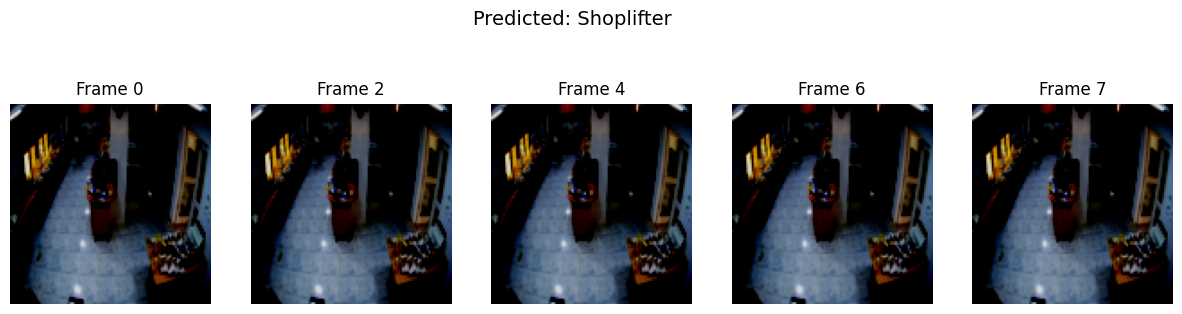

[Sample 2] True Label: Non-Shoplifter | Predicted: Non-Shoplifter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.88235295].


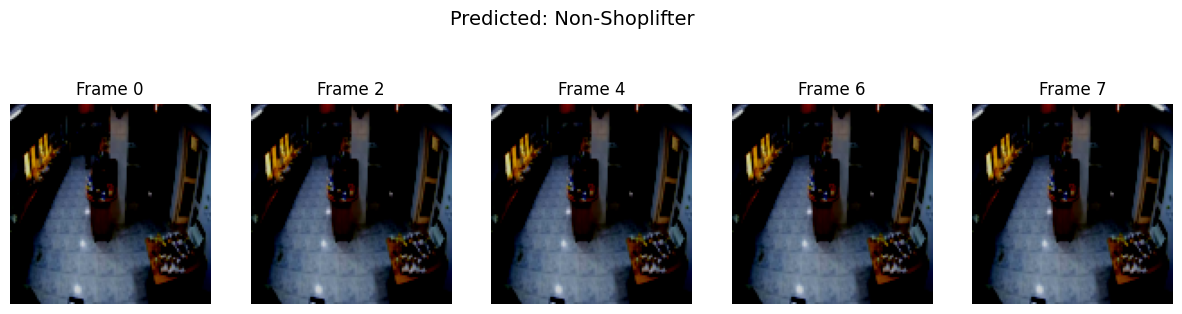

[Sample 3] True Label: Shoplifter | Predicted: Shoplifter


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].


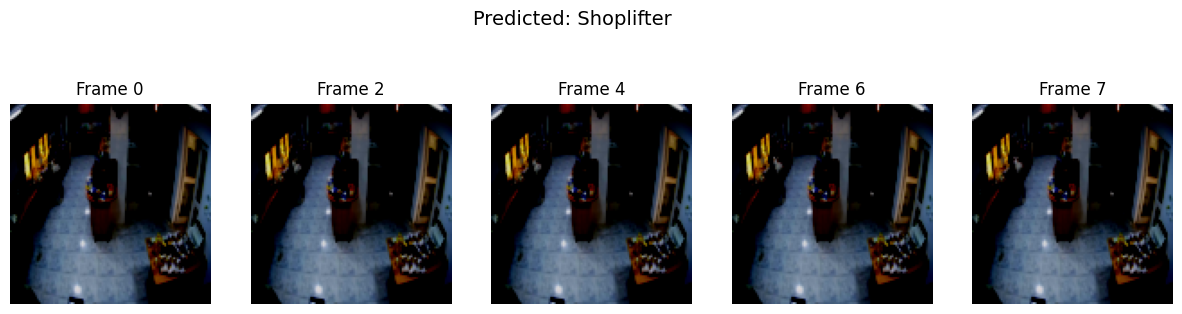

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.8666667].


[Sample 4] True Label: Shoplifter | Predicted: Shoplifter


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].


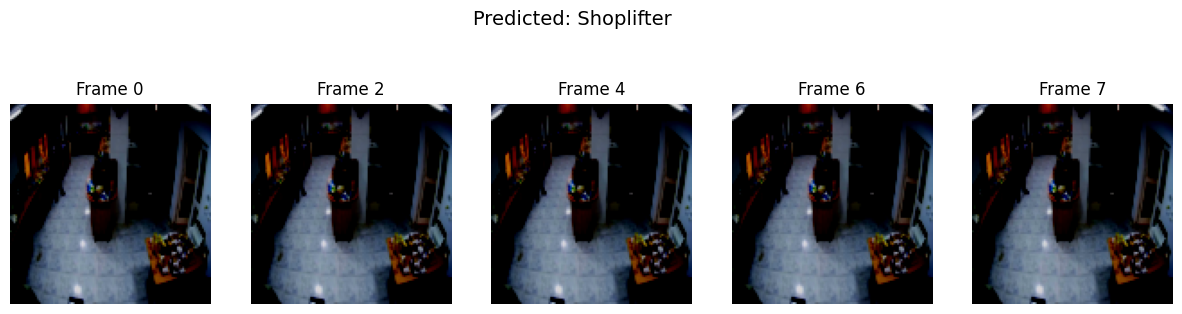

[Sample 5] True Label: Shoplifter | Predicted: Shoplifter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.85882354].


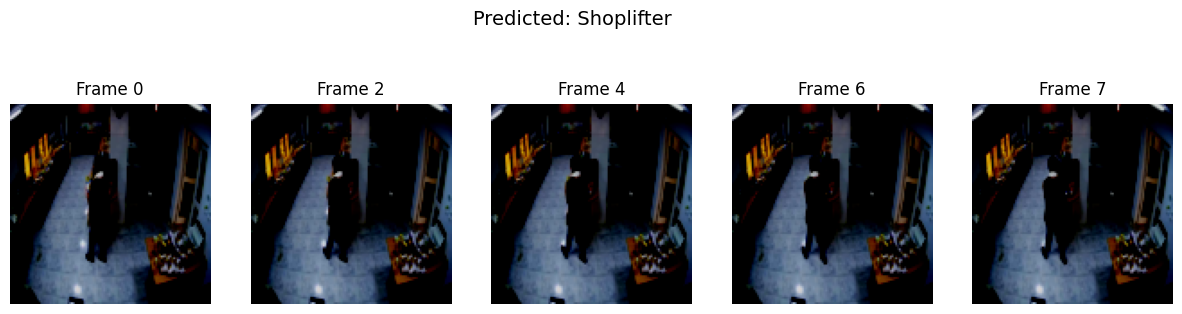

In [39]:
import random
import torch
import matplotlib.pyplot as plt

# Set model to eval mode
model.eval()

# Randomly pick N clips
num_samples = 5
sample_indices = random.sample(range(len(dataset)), num_samples)

class_names = ["Non-Shoplifter", "Shoplifter"]

for i, idx in enumerate(sample_indices):
    clip, true_label = dataset[idx]
    clip = clip.unsqueeze(0).to(device)  # Add batch dimension
    clip = clip.permute(0, 2, 1, 3, 4)    # [B, C, T, H, W]

    with torch.no_grad():
        output = model(clip)
        pred_label = torch.argmax(output, dim=1).item()

    print(f"[Sample {i+1}] True Label: {class_names[true_label]} | Predicted: {class_names[pred_label]}")

    # Optional: visualize a few frames
    frame_indices = [0, 2, 4, 6, 7]
    fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 4))
    for j, frame_idx in enumerate(frame_indices):
        frame = clip[0, :, frame_idx].cpu().permute(1, 2, 0).numpy()
        axes[j].imshow(frame)
        axes[j].axis('off')
        axes[j].set_title(f"Frame {frame_idx}")
    plt.suptitle(f"Predicted: {class_names[pred_label]}", fontsize=14)
    plt.show()


Pre Trained Model 


In [41]:
import os, re, random
from pathlib import Path

import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedShuffleSplit

from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

# ----------------- CONFIG -----------------
# >>>>> CHANGE THIS to your videos root folder <<<<<
DATASET_ROOT =Path("processed_clips")  # has the 2 class folders inside

CLASS_NAMES = ["non_shop_lifters", "shop_lifters"]   # keep your labels as before
ID2LABEL = {0: CLASS_NAMES[0], 1: CLASS_NAMES[1]}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

CLIP_LEN = 8             # number of frames per clip (8 or 16)
FRAME_STRIDE = 2          # sample every n-th frame when building a clip
BATCH_SIZE = 3            # adjust for VRAM
EPOCHS = 10
LR = 1e-4                 # lower LR for finetuning transformers
PATIENCE = 5              # early stopping
CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
NUM_WORKERS = 0           # Windows-safe; try 2-4 later if stable

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);  torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

SAVE_DIR = Path("videomae_on_frames")
SAVE_DIR.mkdir(parents=True, exist_ok=True)


In [42]:
import re
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

def index_clips_grouped(data_root: Path, class_names, recursive=True, exts=("pt","pth")):
    rows = []  # (path, label, group_id)
    for label, cname in enumerate(class_names):
        cdir = data_root / cname
        if not cdir.exists():
            print(f"WARNING: missing folder {cdir}")
            continue
        for ext in exts:
            pattern = "**/*." + ext if recursive else "*." + ext
            for p in cdir.glob(pattern):
                stem = p.stem
                # group id = everything before `_clip<number>`
                m = re.match(r"^(.*?)(?:_clip\d+).*", stem, flags=re.IGNORECASE)
                group_id = m.group(1) if m else stem
                rows.append((p.as_posix(), label, f"{cname}:{group_id}"))
    return rows

rows = index_clips_grouped(DATA_ROOT, CLASS_NAMES)
print(f"Found {len(rows)} clip files.")
if not rows:
    raise RuntimeError(f"No .pt/.pth clips found under {DATA_ROOT.resolve()}")

# Split by group (to avoid leakage); fall back to stratified if grouping didn't help
paths, labels, groups = zip(*rows)
use_groups = len(set(groups)) < len(groups)

if use_groups:
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(paths, labels, groups))
else:
    print("Could not infer groups; using stratified clip-level split.")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(paths, labels))

train_rows = [rows[i] for i in train_idx]
val_rows   = [rows[i] for i in val_idx]
print(f"Train clips: {len(train_rows)} | Val clips: {len(val_rows)} | Groups used: {use_groups}")


Found 35059 clip files.
Train clips: 28087 | Val clips: 6972 | Groups used: True


In [49]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClipPtDataset(Dataset):
    def __init__(self, rows):
        self.rows = rows

    def __len__(self): return len(self.rows)

    def __getitem__(self, i):
        path, label, group = self.rows[i]
        clip = torch.load(path)  # [T,C,H,W]
        if clip.dtype != torch.float32:
            clip = clip.float()
            if clip.max() > 1.5:  # 0..255 -> 0..1
                clip = clip / 255.0
        return clip, int(label), path, group

def collate_batch(batch):
    clips, labels, paths, groups = zip(*batch)
    clips  = torch.stack(clips, dim=0)           # [B,T,C,H,W]
    labels = torch.tensor(labels, dtype=torch.long)
    return clips, labels, paths, groups

train_ds = ClipPtDataset(train_rows)
val_ds   = ClipPtDataset(val_rows)

# Windows-safe defaults; bump workers later if you want
NUM_WORKERS = 0
BATCH_SIZE = 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_batch)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_batch)

# quick sanity check
xb, yb, *_ = next(iter(train_loader))
print("one batch:", xb.shape, yb.shape)


one batch: torch.Size([4, 8, 3, 112, 112]) torch.Size([4])


C:\Users\youss\AppData\Local\Temp\ipykernel_32640\1894251781.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip = torch.load(path)  # [T,C,H,W]


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from torchvision.transforms.functional import to_pil_image
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

# ---- FIX HERE (labels if you want pretty names) ----
try:
    # If you already defined CLASS_NAMES elsewhere, reuse them:
    ID2LABEL = {0: CLASS_NAMES[0], 1: CLASS_NAMES[1]}
except Exception:
    ID2LABEL = {0: "non_shop_lifter", 1: "shop_lifter"}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"    # FIX HERE if you want a different checkpoint
TARGET_SIZE = 112                                     # << lower input resolution
TARGET_T = 16                                         # VideoMAE expects 16 frames
PATCH = 16                                            # VideoMAE uses 16x16 patches by default

def _resample_to_T(frames_tensor: torch.Tensor, target_T: int) -> torch.Tensor:
    """frames_tensor: [T, C, H, W] -> exactly target_T frames via uniform sampling (works for T < or >)."""
    T = frames_tensor.shape[0]
    if T == target_T:
        return frames_tensor
    idx = torch.linspace(0, max(0, T-1), steps=target_T, device=frames_tensor.device).round().long()
    return frames_tensor.index_select(0, idx)

def _interp_pos_embed_112(model, target_T=TARGET_T, target_img=TARGET_SIZE, patch=PATCH):
    """
    Interpolate learned position embeddings from original grid (e.g., T/2 x 14 x 14)
    to new grid (T/2 x (target_img/patch) x (target_img/patch)).
    """
    pos = model.videomae.embeddings.position_embeddings  # [1, old_seq, C]
    if pos is None:
        return

    C = pos.shape[-1]
    old_seq = pos.shape[1]

    # Original spatial grid size (assumes pos tokens are (T/2) * H * W)
    t_old = max(1, target_T // 2)  # VideoMAE uses T/2 tokens along time
    # infer old H*W
    if old_seq % t_old != 0:
        # If mismatch, try deducing t_old from config
        t_old = max(1, int(getattr(model.config, "num_frames", 16)) // 2)
        if old_seq % t_old != 0:
            # Give up interpolation; let model learn new pos from scratch
            with torch.no_grad():
                model.videomae.embeddings.position_embeddings = nn.Parameter(
                    torch.zeros(1, (target_T//2) * (target_img//patch) * (target_img//patch), C, device=pos.device)
                )
            return

    hw_old = old_seq // t_old
    h_old = w_old = int(hw_old ** 0.5)
    if h_old * w_old != hw_old:
        # Non-square grid; bail to fresh param
        with torch.no_grad():
            model.videomae.embeddings.position_embeddings = nn.Parameter(
                torch.zeros(1, (target_T//2) * (target_img//patch) * (target_img//patch), C, device=pos.device)
            )
        return

    h_new = w_new = target_img // patch
    if h_new == h_old and w_new == w_old:
        return  # same spatial, nothing to do

    # reshape to [1, C, t, h, w]
    pos_5d = pos[0].reshape(t_old, h_old, w_old, C).permute(3, 0, 1, 2).unsqueeze(0)
    # interpolate spatial only (keep time same)
    with torch.no_grad():
        pos_5d_resized = F.interpolate(
            pos_5d, size=(t_old, h_new, w_new),
            mode="trilinear", align_corners=False
        )
        pos_new = pos_5d_resized.squeeze(0).permute(1, 2, 3, 0).reshape(1, t_old * h_new * w_new, C)
        model.videomae.embeddings.position_embeddings = nn.Parameter(pos_new)

class HFVideoMAEWrapper(nn.Module):
    def __init__(self, ckpt=CKPT, num_labels=2, device=DEVICE,
                 target_size: int = TARGET_SIZE, target_T: int = TARGET_T):
        super().__init__()
        # Processor: downscale/crop to 112
        try:
            self.processor = VideoMAEImageProcessor.from_pretrained(
                ckpt,
                size={"shortest_edge": target_size},
                crop_size=target_size,
            )
        except TypeError:
            self.processor = VideoMAEImageProcessor.from_pretrained(
                ckpt,
                size=target_size,
                crop_size=target_size,
            )

        # Model
        self.model = VideoMAEForVideoClassification.from_pretrained(
            ckpt,
            num_labels=num_labels,
            id2label=ID2LABEL, label2id=LABEL2ID,
            ignore_mismatched_sizes=True
        ).to(device)

        # Make model expect 112x112 and adjust patch embed & pos embed
        self.model.config.image_size = target_size
        self.model.videomae.embeddings.patch_embeddings.image_size = (target_size, target_size)
        _interp_pos_embed_112(self.model, target_T=target_T, target_img=target_size, patch=PATCH)

        self.device = device
        self.target_T = int(getattr(self.model.config, "num_frames", target_T))  # usually 16

    @torch.no_grad()
    def _prep_batch(self, clips):  # clips: [B, T, C, H, W] on CPU
        batch_frames = []
        for i in range(clips.size(0)):
            clip_TCHW = _resample_to_T(clips[i], self.target_T)
            frames = [to_pil_image(clip_TCHW[t].cpu()) for t in range(self.target_T)]
            batch_frames.append(frames)
        enc = self.processor(batch_frames, return_tensors="pt")  # -> pixel_values [B,C,T,H,W]
        return {k: v.to(self.device) for k, v in enc.items()}

    def forward(self, clips):  # returns logits [B, 2]
        enc = self._prep_batch(clips)
        out = self.model(**enc)
        return out.logits

In [38]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: True
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [53]:
# -------- Training (expects train_loader / val_loader to already exist) --------
# FIX HERE if you want to freeze backbone for speed:
FREEZE_BACKBONE = True     # set True to train classifier head only (much faster)
LR = 1e-4 if not FREEZE_BACKBONE else 1e-3   # faster LR if only head is trained
EPOCHS = 10
PATIENCE = 5
SAVE_PATH = "best_videomae_112.pt"           # FIX HERE if you want a different path

model = HFVideoMAEWrapper().train()

if FREEZE_BACKBONE:
    for n, p in model.model.named_parameters():
        if not n.startswith("classifier"):
            p.requires_grad = False

# If you computed class weights earlier, pass them here; otherwise keep None
weights = None
criterion = nn.CrossEntropyLoss(weight=(weights.to(DEVICE) if isinstance(weights, torch.Tensor) else None))

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR
)
scaler = amp.GradScaler('cuda' if DEVICE == 'cuda' else 'cpu', enabled=(DEVICE == 'cuda'))

# quick sanity check that loaders exist
assert 'train_loader' in globals() and 'val_loader' in globals(), "Define train_loader and val_loader first."

best_val, bad = float("inf"), 0
for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    tl, tc, n = 0.0, 0, 0
    for clips, labels, *_ in train_loader:
        labels = labels.to(DEVICE)  # keep clips on CPU; wrapper moves pixel_values to GPU

        optimizer.zero_grad(set_to_none=True)
        with amp.autocast('cuda', enabled=(DEVICE == 'cuda')):
            logits = model(clips)            # wrapper handles processor + device
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tl += float(loss) * labels.size(0)
        tc += (logits.argmax(1) == labels).sum().item()
        n  += labels.size(0)

    tl /= max(1, n); ta = tc / max(1, n)

    # ---- Validate ----
    model.eval()
    vl, vc, n = 0.0, 0, 0
    with torch.no_grad():
        for clips, labels, *_ in val_loader:
            labels = labels.to(DEVICE)
            with amp.autocast('cuda', enabled=(DEVICE == 'cuda')):
                logits = model(clips)
                loss = criterion(logits, labels)
            vl += float(loss) * labels.size(0)
            vc += (logits.argmax(1) == labels).sum().item()
            n  += labels.size(0)

    vl /= max(1, n); va = vc / max(1, n)
    print(f"Epoch {epoch:02d} | train_loss {tl:.4f} acc {ta:.3f} | val_loss {vl:.4f} acc {va:.3f}")

    if vl + 1e-5 < best_val:
        best_val, bad = vl, 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping."); break

print("Saved best weights to:", SAVE_PATH)


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\youss\AppData\Local\Temp\ipykernel_32640\1894251781.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

Epoch 01 | train_loss 0.1846 acc 0.936 | val_loss 0.1149 acc 0.963
Epoch 02 | train_loss 0.0924 acc 0.970 | val_loss 0.0924 acc 0.969
Epoch 03 | train_loss 0.0722 acc 0.976 | val_loss 0.0976 acc 0.971
Epoch 04 | train_loss 0.0602 acc 0.980 | val_loss 0.0901 acc 0.973
Epoch 05 | train_loss 0.0531 acc 0.982 | val_loss 0.0869 acc 0.975
Epoch 06 | train_loss 0.0471 acc 0.985 | val_loss 0.0864 acc 0.974
Epoch 07 | train_loss 0.0432 acc 0.986 | val_loss 0.0837 acc 0.978
Epoch 08 | train_loss 0.0400 acc 0.987 | val_loss 0.0806 acc 0.978
Epoch 09 | train_loss 0.0366 acc 0.988 | val_loss 0.0834 acc 0.977
Epoch 10 | train_loss 0.0349 acc 0.989 | val_loss 0.0820 acc 0.980
Saved best weights to: best_videomae_112.pt


C:\Users\youss\AppData\Local\Temp\ipykernel_32640\1894251781.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clip = torch.load(path)  # [T,C,H,W]


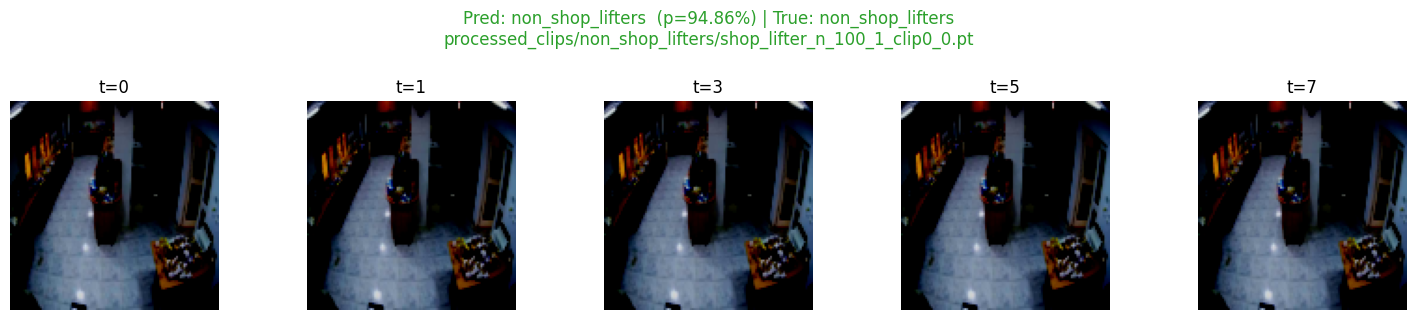

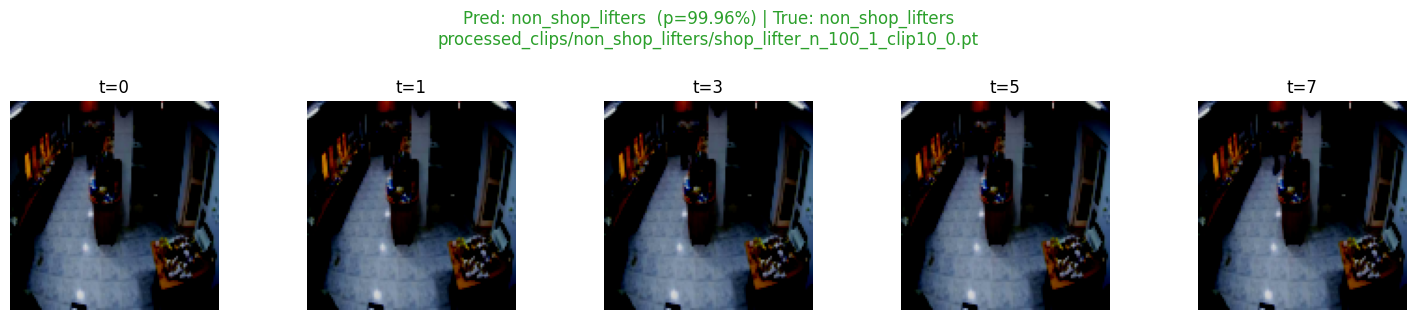

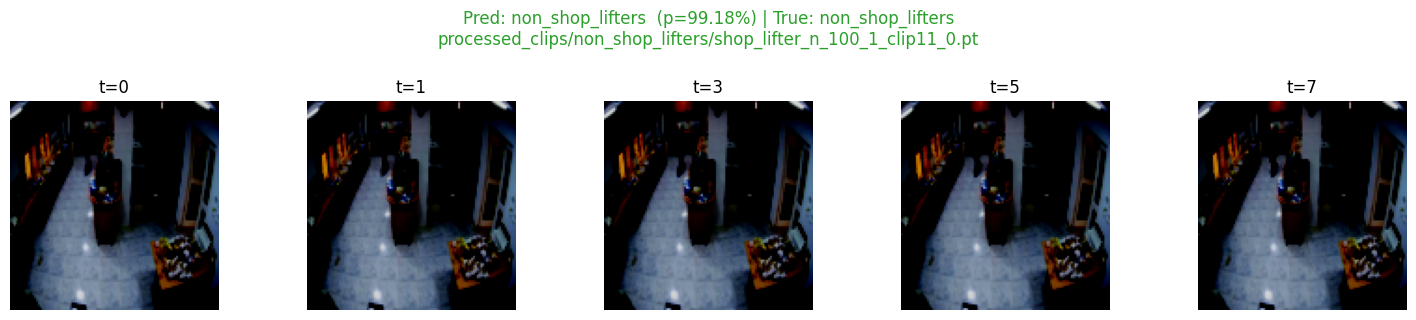

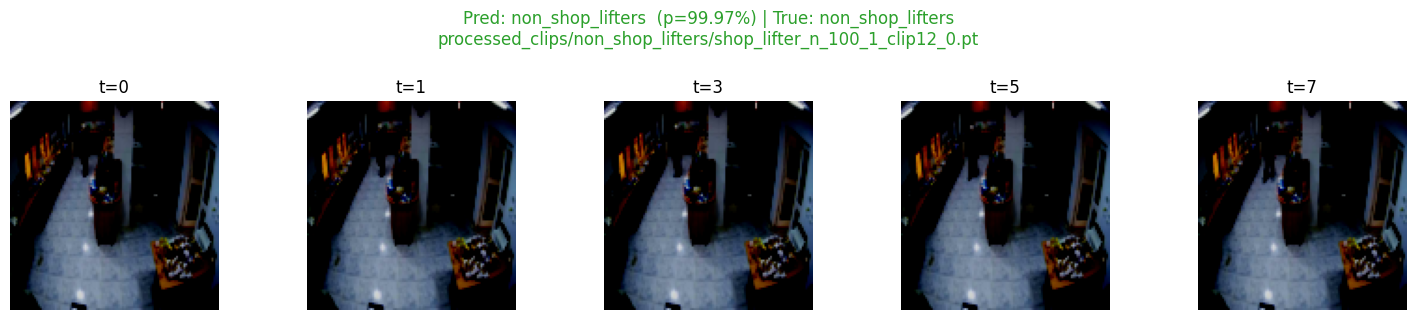

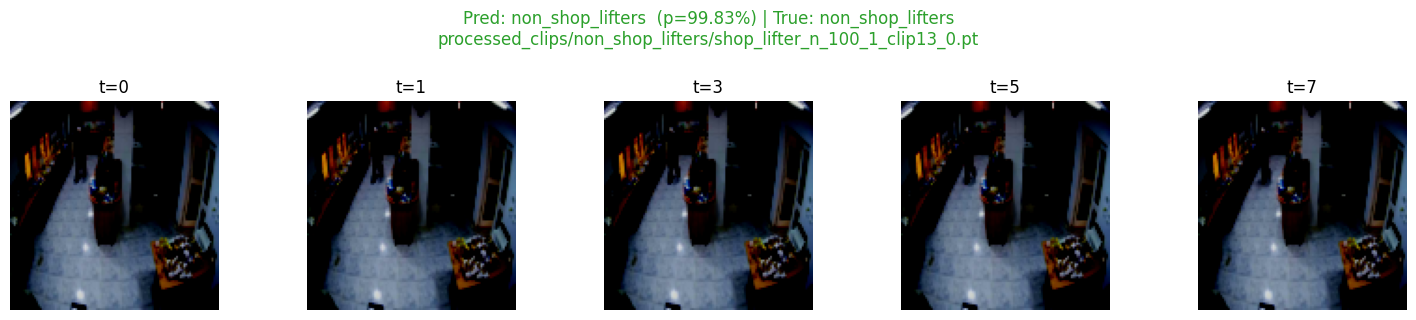

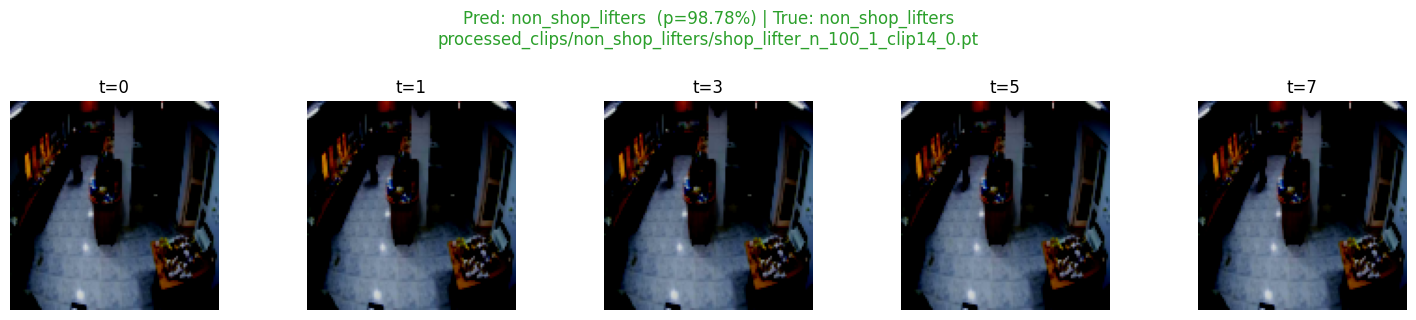

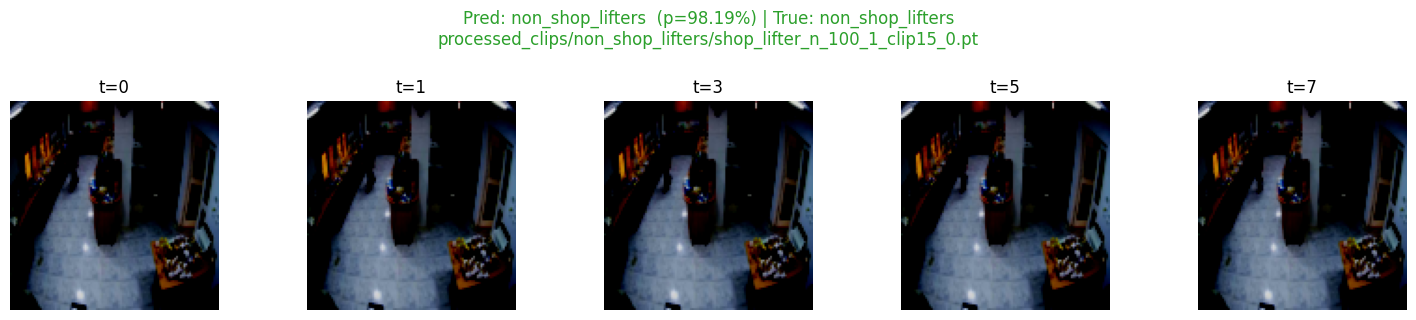

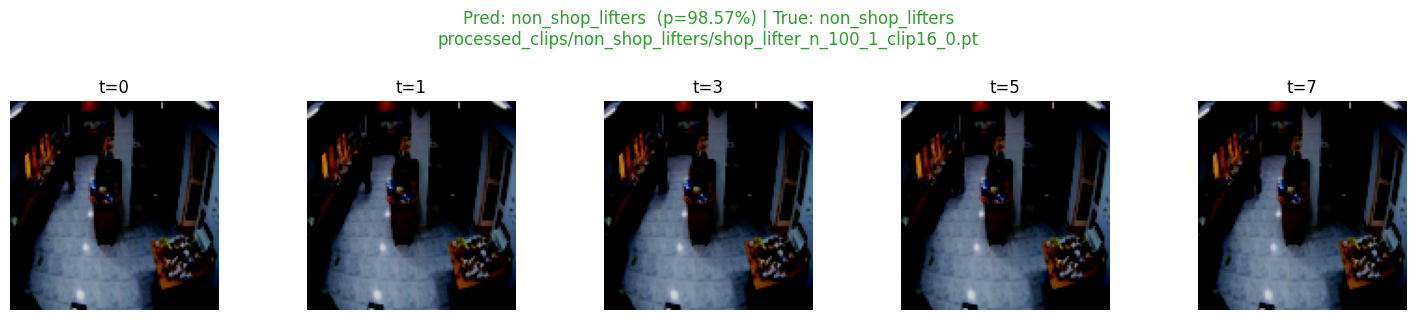

In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# --- helper: pick evenly spaced frame indices from a clip ---
def pick_frames(T, k=5):
    k = min(k, T)
    return np.linspace(0, T-1, num=k, dtype=int).tolist()

# --- visualize one clip (grid of frames) ---
def show_clip(clip_TCHW, pred_id, true_id, conf, path=None, k=5):
    T = clip_TCHW.shape[0]
    idxs = pick_frames(T, k)
    fig, axes = plt.subplots(1, len(idxs), figsize=(3*len(idxs), 3))
    if len(idxs) == 1:
        axes = [axes]

    for ax, t in zip(axes, idxs):
        img = clip_TCHW[t].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)  # just in case
        ax.imshow(img)
        ax.set_title(f"t={t}")
        ax.axis("off")

    correct = (pred_id == true_id)
    title_color = "tab:green" if correct else "tab:red"
    pred_name = ID2LABEL[pred_id]
    true_name = ID2LABEL[true_id]
    top = f"Pred: {pred_name}  (p={conf:.2%}) | True: {true_name}"
    if path is not None:
        top += f"\n{path}"
    fig.suptitle(top, color=title_color, fontsize=12, y=1.05)
    plt.tight_layout()
    return fig

# --- preview N batches (non-streaming) ---
def preview_predictions(model, loader, batches=2, frames_per_clip=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for clips, labels, paths, *rest in loader:
            logits = model(clips)                           # wrapper handles device
            probs  = logits.softmax(1).cpu()
            preds  = probs.argmax(1)

            for i in range(clips.size(0)):
                p_id = int(preds[i])
                t_id = int(labels[i])
                conf = float(probs[i, p_id])
                fig = show_clip(clips[i], p_id, t_id, conf, path=paths[i], k=frames_per_clip)
                plt.show()

            shown += 1
            if shown >= batches:
                break

# --- live stream through the loader (updates the same cell output) ---
def stream_predictions(model, loader, frames_per_clip=5, max_batches=None):
    model.eval()
    seen = 0
    with torch.no_grad():
        for bi, (clips, labels, paths, *rest) in enumerate(loader):
            logits = model(clips)
            probs  = logits.softmax(1).cpu()
            preds  = probs.argmax(1)

            clear_output(wait=True)
            # show up to 3 clips from this batch to avoid huge output
            n_show = min(3, clips.size(0))
            for i in range(n_show):
                p_id = int(preds[i]); t_id = int(labels[i])
                conf = float(probs[i, p_id])
                fig = show_clip(clips[i], p_id, t_id, conf, path=paths[i], k=frames_per_clip)
                display(fig)
                plt.close(fig)

            print(f"Batch {bi+1} | showing {n_show}/{clips.size(0)} clips")
            seen += 1
            if max_batches is not None and seen >= max_batches:
                break

# ---------- how to use ----------
# Quick peek at 2 batches:
preview_predictions(model, val_loader, batches=2, frames_per_clip=5)

# OR stream live as you iterate (stop the cell whenever you like):
# stream_predictions(model, val_loader, frames_per_clip=5, max_batches=10)
